## Importing libraries 

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install neattext
import neattext.functions as nfx

## SMS Spam Data Loading 

In [65]:
#train data
# sms spam data loading 
df= pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding= 'ISO-8859-1', encoding_errors = 'strict')


In [66]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Remove unnecessary columns

In [67]:
#Remove unnecessary columns
df=df.drop(df.columns[[2,3,4]], axis=1)

In [68]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##  Renaming multiple columns

In [69]:

df.rename(columns={'v1': 'Label', 'v2': 'Text'}, inplace=True)

In [70]:
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [71]:
df.columns

Index(['Label', 'Text'], dtype='object')

In [72]:
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

Text(0, 0.5, 'Genre')

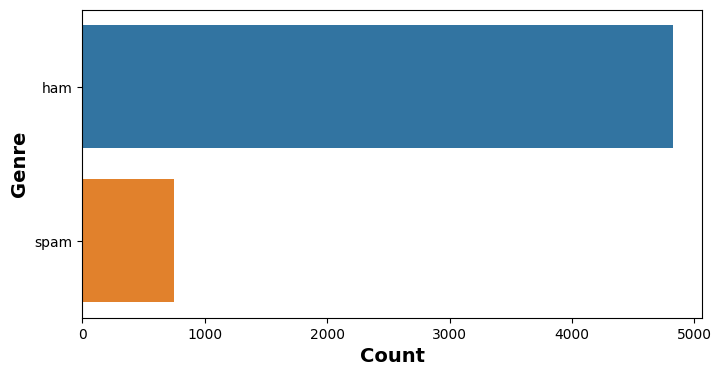

In [73]:
import seaborn as sns
plt.figure(figsize=(8,4))
counts = df['Label'].value_counts()
sns.barplot(x=counts, y=counts.index)  
plt.xlabel('Count',fontsize=14, fontweight='bold')
plt.ylabel('Genre',fontsize=14, fontweight='bold')

# Cleaning Data

In [74]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [75]:
data_len=df['Text'].apply(len)

In [76]:
cleaned_df,cleaned_data_len=clean_text(df["Text"])


100%|██████████| 5572/5572 [00:00<00:00, 93922.58it/s]


In [77]:

df['original_len'] = data_len
df['Text'] = cleaned_df
df['cleaned_len'] = cleaned_data_len


df.head()

,Label,Text,original_len,cleaned_len
0,ham,jurong point crazy available bugis n great wor...,111,15
1,ham,ok lar joking wif u oni,29,6
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,155,22
3,ham,u dun early hor u c,49,6
4,ham,nah dont think goes usf lives,61,6


In [78]:
# Label data are convert into a decimal number just label encoding using by lambda
df.Label=df.Label.apply(lambda x: 1 if x=="spam" else 0)

In [79]:
df.head()

,Label,Text,original_len,cleaned_len
0,0,jurong point crazy available bugis n great wor...,111,15
1,0,ok lar joking wif u oni,29,6
2,1,free entry 2 wkly comp win fa cup final tkts 2...,155,22
3,0,u dun early hor u c,49,6
4,0,nah dont think goes usf lives,61,6


# Spliting Data set

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)


### Data Preprocessing

In [81]:

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [82]:
class_counts_before = y_train.value_counts()
class_counts_after = pd.Series(y_train_resampled).value_counts()




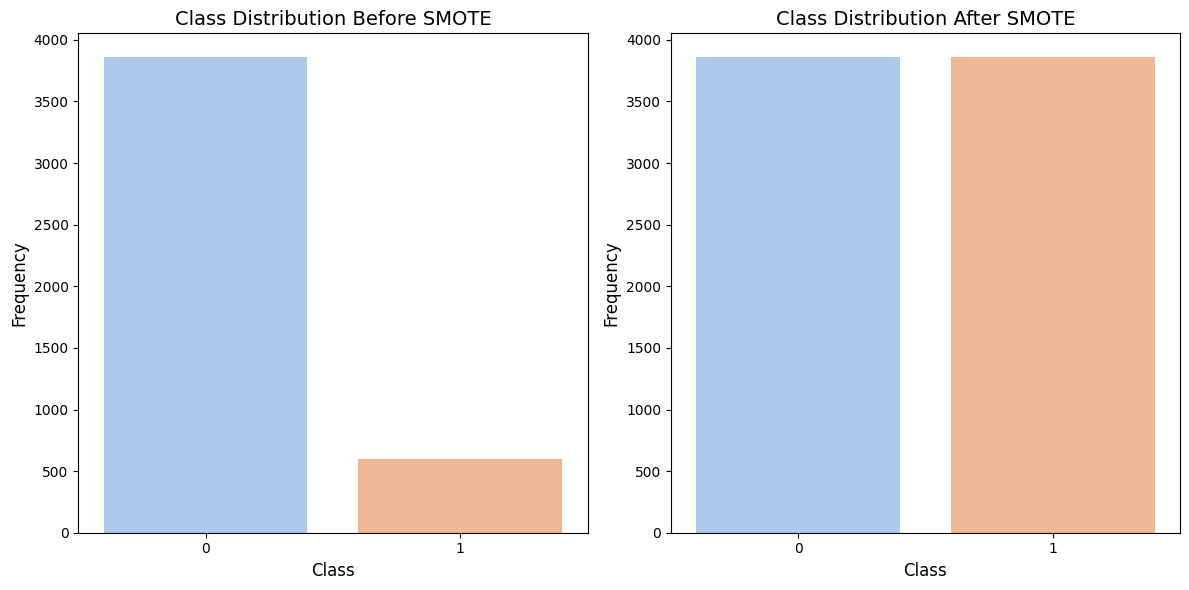

In [83]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=class_counts_before.index, y=class_counts_before.values, palette="pastel")
plt.title("Class Distribution Before SMOTE", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x=class_counts_after.index, y=class_counts_after.values, palette="pastel")
plt.title("Class Distribution After SMOTE", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

## naive_bayes classifer before smote

In [84]:
from sklearn.naive_bayes import MultinomialNB

NB=MultinomialNB()
NB.fit(X_train_tfidf, y_train)

MultinomialNB()

In [85]:
y_pred1=NB.predict(X_test_tfidf)

In [86]:
# Evaluate the model on the testing data
accuracy = NB.score(X_test_tfidf, y_test)
print("Accuracy:", accuracy)  

Accuracy: 0.967713004484305


In [87]:
from sklearn.metrics import *
def evaluate(test, pred):
    accuracy = accuracy_score(test, pred)
    cf_report = classification_report(test, pred)
    precision = precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average='macro')
    f1 = f1_score(test, pred, average='macro')
    
    print('Accuracy', accuracy)
    print('Classification Report', cf_report)
    print('Precision', precision)
    print('Recall', recall)
    print('F1-Score', f1)

In [88]:
evaluate(y_test,y_pred1)

Accuracy 0.967713004484305
Classification Report               precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.76      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

Precision 0.982017982017982
Recall 0.88
F1-Score 0.9226625358364932


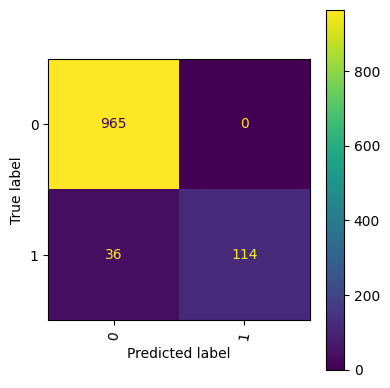

In [89]:
fig, ax = plt.subplots(figsize=(4, 4))
    # Create the confusion matrix
cm = confusion_matrix(y_test, y_pred1)
cmp = ConfusionMatrixDisplay(cm, display_labels=NB.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### naive_bayes classifier model after Smote


In [90]:
from sklearn.naive_bayes import MultinomialNB

NB2=MultinomialNB()
NB2.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [91]:
y_pred2=NB2.predict(X_test_tfidf)

In [92]:
# Evaluate the model on the testing data
accuracy = NB2.score(X_test_tfidf, y_test)
print("Accuracy:", accuracy)  

Accuracy: 0.9641255605381166


In [93]:
evaluate(y_test,y_pred2)

Accuracy 0.9641255605381166
Classification Report               precision    recall  f1-score   support

           0       0.99      0.97      0.98       965
           1       0.83      0.93      0.87       150

    accuracy                           0.96      1115
   macro avg       0.91      0.95      0.93      1115
weighted avg       0.97      0.96      0.96      1115

Precision 0.9078826620405289
Recall 0.948307426597582
F1-Score 0.9266466671929687


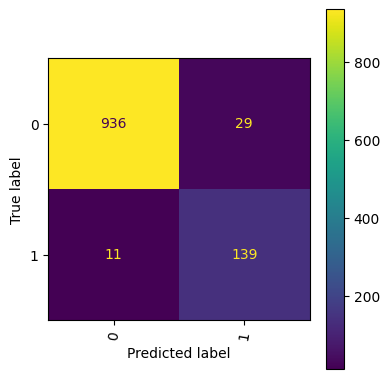

In [95]:
fig, ax = plt.subplots(figsize=(4, 4))
    # Create the confusion matrix
cm = confusion_matrix(y_test, y_pred2)
cmp = ConfusionMatrixDisplay(cm, display_labels=NB.classes_)
cmp.plot(ax=ax)
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

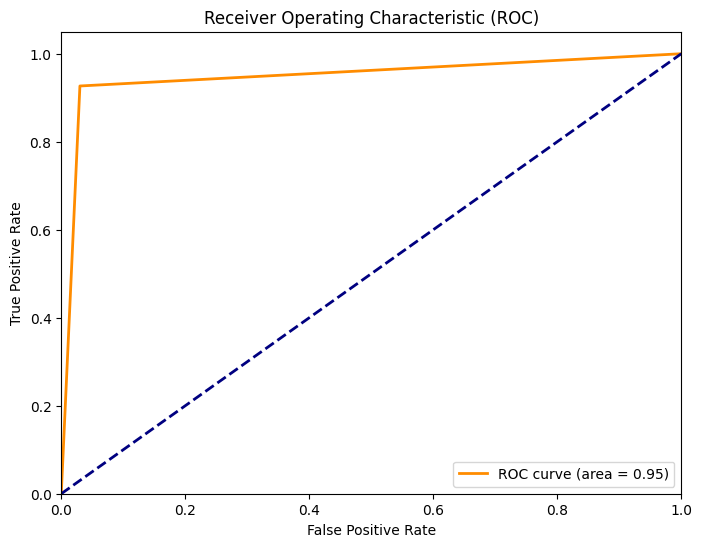

AUC-ROC: 0.9483074265975822


In [96]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


print("AUC-ROC:", roc_auc)

# Support Vector classifer befor and after smote the dataset

In [124]:
svm_classifier = SVC(kernel='linear')  # You can experiment with different kernels ('linear', 'rbf', "poly".)
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_classifier2 = SVC(kernel='linear')
svm_classifier2.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [125]:
y_pred11=svm_classifier.predict(X_test_tfidf)
y_pred22=svm_classifier2.predict(X_test_tfidf)

In [126]:
# Evaluate the model on the testing data
acc1= svm_classifier.score(X_test_tfidf, y_test)
print("Accuracy of svm after smote:", acc1)  

# Evaluate the model on the testing data
acc2 = svm_classifier2.score(X_test_tfidf, y_test)
print("Accuracy of svm before smote:", acc2)  

Accuracy of svm after smote: 0.9811659192825112
Accuracy of svm before smote: 0.9811659192825112


In [127]:
evaluate(y_test,y_pred11)

Accuracy 0.9811659192825112
Classification Report               precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Precision 0.9738176671777332
Recall 0.9440759930915371
F1-Score 0.9582582373798687


In [128]:
evaluate(y_test,y_pred22)

Accuracy 0.9811659192825112
Classification Report               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Precision 0.9828070685879668
Recall 0.9356303972366149
F1-Score 0.9575046143291935
